In [1]:
from config import *
import pandas as pd
import codecs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

In [2]:
def deumlaut(s):
    """
    Replaces umlauts with fake-umlauts
    """
    s = s.replace('\\xdf', 'ss')
    s = s.replace('\\xfc', 'ue')
    s = s.replace('\\xdc', 'Ue')
    s = s.replace('\\xf6', 'oe')
    s = s.replace('\\xd6', 'Oe')
    s = s.replace('\\xe4', 'ae')
    s = s.replace('\\xc4', 'Ae')
    return s

In [3]:
col_names = ["master_number", "target_variable", "day", "month", "duration", "call_id", "age", "gender", "type_of_employment", "marital_status", 'education', "credit_failure", "account_balance", "house", "credit", "contact_type", "number_of_speeches", "days_since_last_campaign", "number_of_contacts_last_campaign", "result_last_campaign"]
data_type = {"master_number": int, "target_variable": str, "day":int, "month": object, "duration": int, "call_id": int,
       "age": int, "gender": object, "type_of_employment": object, "marital_status": object, 'education': object,
       "credit_failure": object, "account_balance": int, "house": object, "credit": object, "contact_type": object,
       "number_of_speeches": int, "days_since_last_campaign": float, "number_of_contacts_last_campaign": int,
       "result_last_campaign": object}
names_utf = ['target_variable', 'month', 'gender', 'type_of_employment', 'marital_status', 'education','credit_failure', "house", 'credit', 'contact_type','result_last_campaign']
train = pd.read_csv(file_config['train'], encoding = 'cp273', sep=';', skiprows=[0], index_col=False,
                    names=col_names, dtype=data_type)
test = pd.read_csv(file_config['test'], encoding = 'cp273', sep=';', skiprows=[0], index_col=False,
                    names=col_names, dtype=data_type)
train['is_train'] = pd.Series(data=[True for i in range(train.shape[0])])
test['is_train'] = pd.Series(data=[False for i in range(test.shape[0])])
col_names.append('is_train')
data = pd.concat([train[col_names], test[col_names]])
# Convert to category data type
for col_name in ['target_variable', 'month', 'gender', 'type_of_employment', 'marital_status', 'education', 'credit_failure', 'house', 'credit', 'contact_type', 'result_last_campaign']:
    data[col_name] = data[col_name].astype('category')
# Convert encoding
for name in names_utf:
    try:
        data[name] = data.loc[:,name].map(lambda x: deumlaut(x.encode('cp273').decode('utf8', 'strict')))
    except (UnicodeDecodeError, AttributeError):
        print(name)

type_of_employment


In [4]:
# Convert encoding if there is any umlaut
name='type_of_employment'
data[name] = data.loc[:,name].map(lambda x: x.encode('cp273').decode('utf8', "backslashreplace")).apply(lambda x:deumlaut(x))

In [5]:
data.target_variable.unique()

[nein, ja, NaN]
Categories (2, object): [nein, ja]

In [6]:
data.head()

,master_number,target_variable,day,month,duration,call_id,age,gender,type_of_employment,marital_status,...,credit_failure,account_balance,house,credit,contact_type,number_of_speeches,days_since_last_campaign,number_of_contacts_last_campaign,result_last_campaign,is_train
0,432148809,nein,27,may,166,623,30,w,Arbeiter,verheiratet,...,nein,-202,nein,nein,Unbekannt,2,NaN,0,Unbekannt,True
1,432184318,nein,26,oct,183,1992,42,w,Management,verheiratet,...,nein,2463,nein,nein,Handy,2,NaN,0,Unbekannt,True
2,432182482,nein,5,jun,227,2778,26,w,Dienstleistung,single,...,nein,2158,ja,ja,Festnetz,1,NaN,0,Unbekannt,True
3,432150520,nein,2,jun,31,3070,34,m,Arbeitslos,geschieden,...,ja,75,ja,nein,Unbekannt,3,NaN,0,Unbekannt,True
4,432145870,nein,15,may,1231,6583,48,m,Arbeiter,verheiratet,...,nein,559,ja,nein,Unbekannt,2,NaN,0,Unbekannt,True


## Compare distribution of each variable in training and testing set

In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import itertools

def compare_distr(df1, df2):
    a = len(df1.columns)
    if a%2 != 0:
        a += 1
    
    n = np.floor(np.sqrt(a)).astype(np.int64)
    
    while a%n != 0:
        n -= 1
    
    m = (a/n).astype(np.int64)
    coords = list(itertools.product(list(range(m)), list(range(n))))
    
    numerics = df1.select_dtypes(include=[np.number]).columns
    cats = df1.select_dtypes(include=['category']).columns
    
    fig = plt.figure(figsize=(15, 15))
    axes = gs.GridSpec(m, n)
    axes.update(wspace=0.25, hspace=0.25)
    
    for i in range(len(numerics)):
        x, y = coords[i]
        ax = plt.subplot(axes[x, y])
        col = numerics[i]
        sns.kdeplot(df1[col].dropna(), ax=ax, label='df1').set(xlabel=col)
        sns.kdeplot(df2[col].dropna(), ax=ax, label='df2')
        
    for i in range(0, len(cats)):
        x, y = coords[len(numerics)+i]
        ax = plt.subplot(axes[x, y])
        col = cats[i]

        df1_temp = df1[col].value_counts()
        df2_temp = df2[col].value_counts()
        df1_temp = pd.DataFrame({col: df1_temp.index, 'value': df1_temp/len(df1), 'Set': np.repeat('df1', len(df1_temp))})
        df2_temp = pd.DataFrame({col: df2_temp.index, 'value': df2_temp/len(df2), 'Set': np.repeat('df2', len(df2_temp))})

        sns.barplot(x=col, y='value', hue='Set', data=pd.concat([df1_temp, df2_temp]), ax=ax).set(ylabel='Percentage')

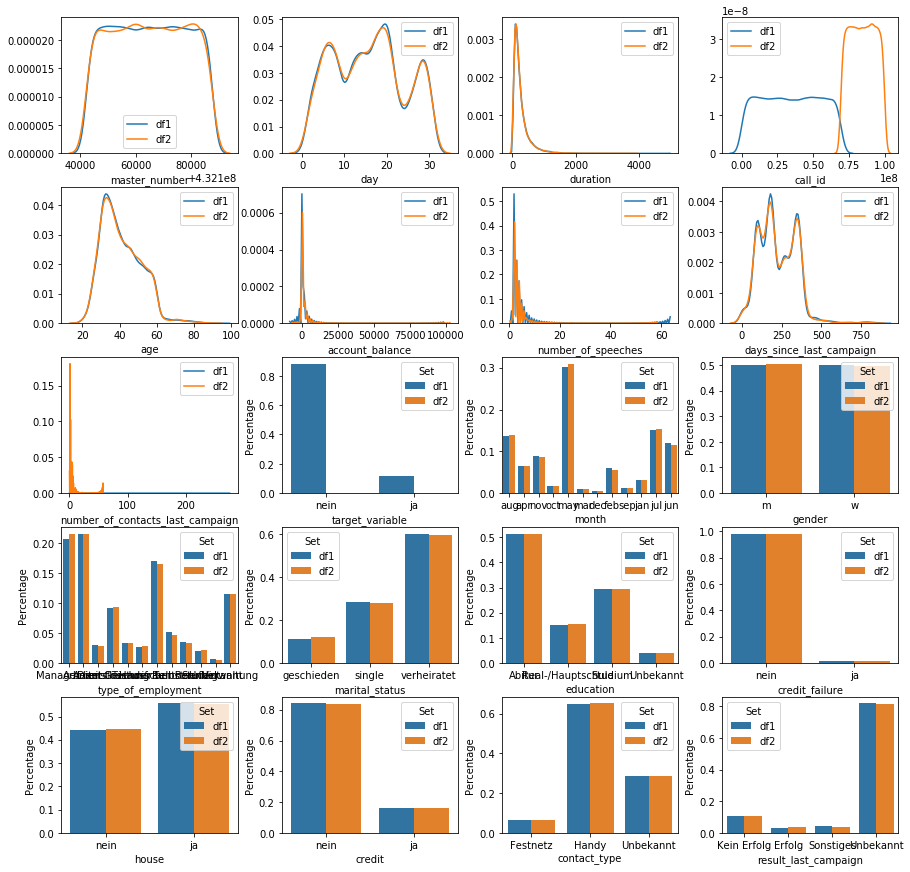

In [8]:
compare_distr(data.loc[data.is_train, :].drop('is_train', 1), data.loc[~data.is_train, :].drop('is_train', 1))

## Investigate if data are missing  randomly

In [9]:
cols_with_missing = [col for col in train.columns if train[col].isnull().any()]
cols_with_missing

['days_since_last_campaign']

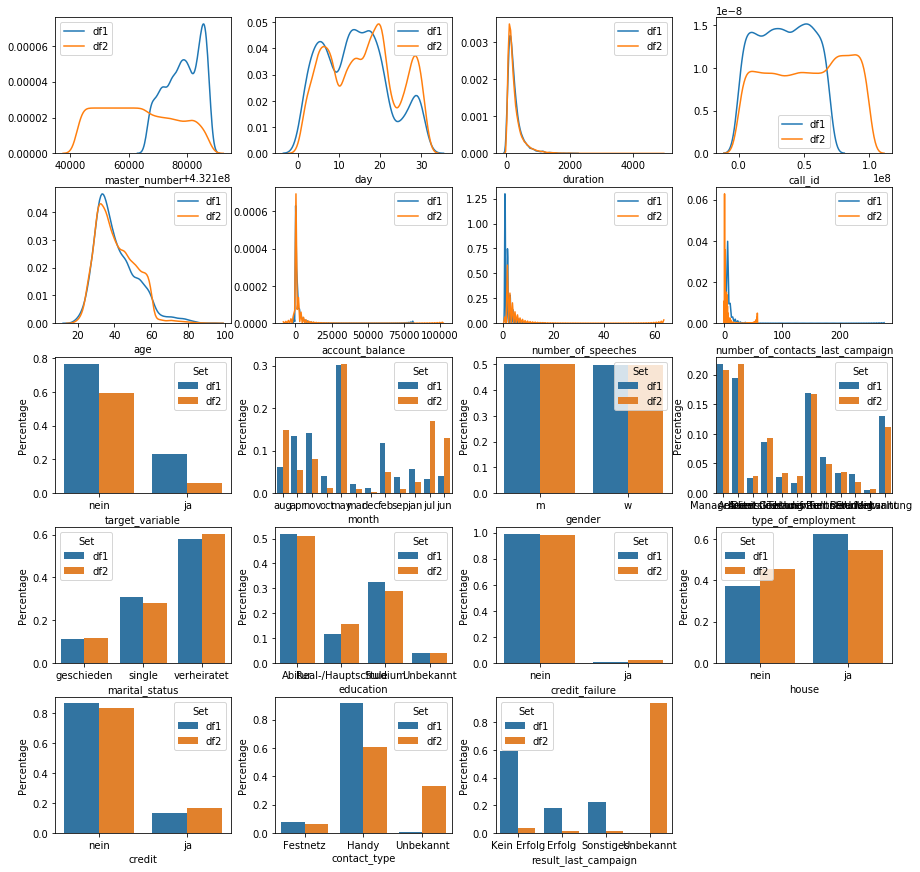

In [10]:
data_present = data.dropna().drop('days_since_last_campaign', 1)
data_missing = data[data.isnull().any(axis=1)].drop('days_since_last_campaign', 1)
compare_distr(data_present.drop('is_train', 1), data_missing.drop('is_train', 1))

`days_since_last_campaign` is more likely to be missing if `result_last_campaign` is `"Unbekannt"` or `contact_type` is `"Unbekannt"`. A possible explanation is that a customer was not contacted in last campaign.

## Visualize distribution of numerical variables

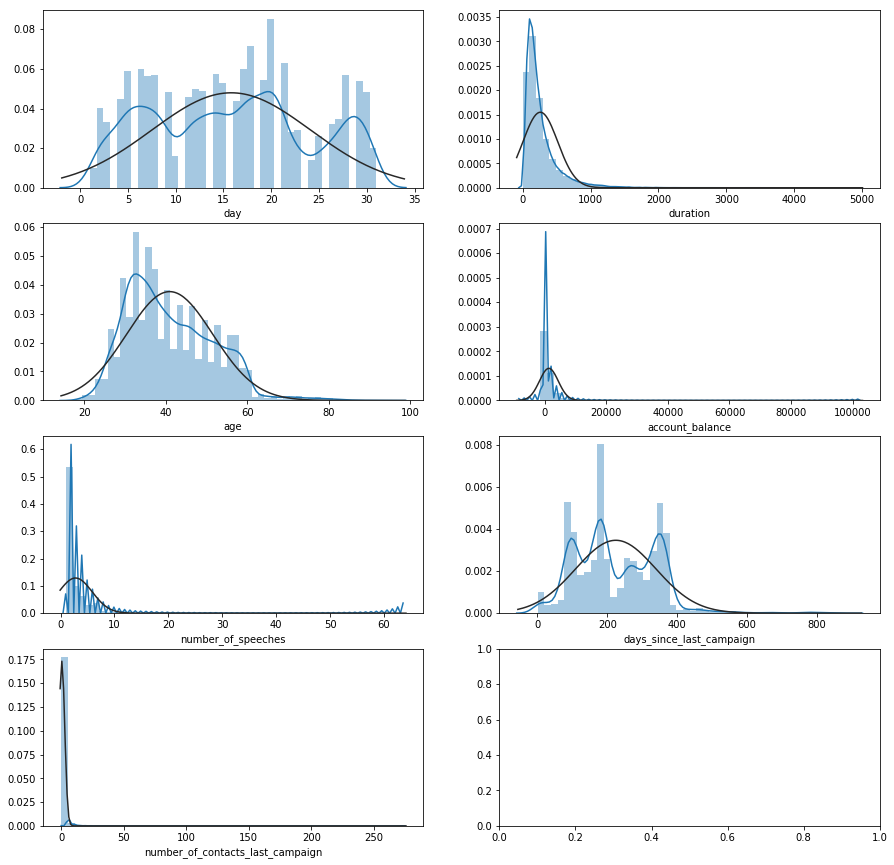

In [11]:
k = 0
f, axarr = plt.subplots(4, 2, figsize=(15,15))
numeric_feats = ['day', 'duration', 'age', 'account_balance', 'number_of_speeches', 'days_since_last_campaign', 'number_of_contacts_last_campaign']
dat_hist = data.loc[:, numeric_feats]
for i in range(4):
    for j in range(2):
        if k != 7:
            sns.distplot(dat_hist.iloc[:, k].dropna() , fit=norm, ax=axarr[i, j])
        k += 1

Some of the numerical features are skewed distributed. As lots of algorithms like normality, Box-Cox transformation should be applied on some of the variables.

## Box-Cox tranformation for some of the numerical features

In [12]:
min_each_col = [np.min(data[feat]) for feat in numeric_feats]
for i, feat in enumerate(numeric_feats):
    data[feat] = data[feat] - min_each_col[i]

In [13]:
from scipy.stats import skew
from scipy.special import boxcox1p
numeric_feats = data.dtypes[numeric_feats].index

# Check the skew of all numerical features
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness_value = pd.DataFrame({'skewness_before' :skewed_feats})
skewness_value['lambda_value'] = np.NaN

In [14]:
from scipy.optimize import minimize

for feat in numeric_feats:
    dat = data[feat]
    def to_minimize(lambda_value):
        tmp = boxcox1p(dat, lambda_value)
        return (skew(tmp.dropna()))**2
    skewness_value.loc[feat, 'lambda_value'] = minimize(to_minimize, x0=0, method='L-BFGS-B', tol=1e-5, bounds=[(-10,10)])['x'][0]
    data[feat] = boxcox1p(data[feat], skewness_value.loc[feat, 'lambda_value'])
skewness_value['skewness_after'] = data[numeric_feats].apply(lambda x: skew(x.dropna()))

In [15]:
skewness_value

,skewness_before,lambda_value,skewness_after
number_of_contacts_last_campaign,41.845066,-7.818474,1.642858e+00
account_balance,8.360031,-0.031087,1.825462e-05
number_of_speeches,4.898488,-0.816897,2.716832e-05
duration,3.144214,0.128995,6.289453e-07
days_since_last_campaign,0.693014,0.631913,2.836684e-05
age,0.684795,0.377269,8.264029e-06
day,0.093076,0.891667,-1.559118e-06


## Scale numerical features

In [16]:
non_missing_num = [feat for feat in numeric_feats if feat != 'days_since_last_campaign']

In [17]:
from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler(feature_range=(0, 1)).fit(data[non_missing_num])
data[non_missing_num] = transformer.transform(data[non_missing_num])

In [18]:
feat = 'days_since_last_campaign'
data[feat] = (data[feat] -  np.min(data[feat]))/(np.max(data[feat]) - np.min(data[feat]))
data.head()

,master_number,target_variable,day,month,duration,call_id,age,gender,type_of_employment,marital_status,...,credit_failure,account_balance,house,credit,contact_type,number_of_speeches,days_since_last_campaign,number_of_contacts_last_campaign,result_last_campaign,is_train
0,432148809,nein,0.878411,may,0.469021,623,0.390946,w,Arbeiter,verheiratet,...,nein,0.802790,nein,nein,Unbekannt,0.447506,NaN,0.0,Unbekannt,True
1,432184318,nein,0.847718,oct,0.481234,1992,0.567369,w,Management,verheiratet,...,nein,0.825465,nein,nein,Handy,0.447506,NaN,0.0,Unbekannt,True
2,432182482,nein,0.157096,jun,0.508795,2778,0.309270,w,Dienstleistung,single,...,nein,0.823192,ja,ja,Festnetz,0.000000,NaN,0.0,Unbekannt,True
3,432150520,nein,0.041990,jun,0.282722,3070,0.458101,m,Arbeitslos,geschieden,...,ja,0.805492,ja,nein,Unbekannt,0.613176,NaN,0.0,Unbekannt,True
4,432145870,nein,0.500066,may,0.754423,6583,0.635587,m,Arbeiter,verheiratet,...,nein,0.809993,ja,nein,Unbekannt,0.447506,NaN,0.0,Unbekannt,True


## Replace missing values with the same value

In [19]:
data.loc[pd.isnull(data.days_since_last_campaign), 'days_since_last_campaign'] = 2.0

## Make dummy variables for categorical features

In [20]:
data = pd.get_dummies(data, columns=['month', 'gender', 'credit_failure', 'type_of_employment', 'marital_status', 'education', 'house', 'credit', 'contact_type','result_last_campaign'], drop_first=True)
data.head()

,master_number,target_variable,day,duration,call_id,age,account_balance,number_of_speeches,days_since_last_campaign,number_of_contacts_last_campaign,...,education_Real-/Hauptschule,education_Studium,education_Unbekannt,house_ja,credit_ja,contact_type_Handy,contact_type_Unbekannt,result_last_campaign_Erfolg,result_last_campaign_Sonstiges,result_last_campaign_Unbekannt
0,432148809,nein,0.878411,0.469021,623,0.390946,0.802790,0.447506,2.0,0.0,...,0,0,0,0,0,0,1,0,0,1
1,432184318,nein,0.847718,0.481234,1992,0.567369,0.825465,0.447506,2.0,0.0,...,0,1,0,0,0,1,0,0,0,1
2,432182482,nein,0.157096,0.508795,2778,0.309270,0.823192,0.000000,2.0,0.0,...,0,0,0,1,1,0,0,0,0,1
3,432150520,nein,0.041990,0.282722,3070,0.458101,0.805492,0.613176,2.0,0.0,...,0,1,0,1,0,0,1,0,0,1
4,432145870,nein,0.500066,0.754423,6583,0.635587,0.809993,0.447506,2.0,0.0,...,1,0,0,1,0,0,1,0,0,1


## Split data into train and test

In [21]:
import pickle
train =  data[data.is_train]
test = data[~data.is_train]
train = train.drop(['is_train'], axis=1)
test = test.drop(['is_train', 'target_variable'], axis=1)
train = pd.get_dummies(train, columns=['target_variable'], drop_first=True)
train.to_pickle(file_config['data_dir'] + 'train.pkl')
test.to_pickle(file_config['data_dir'] + 'test.pkl')

In [22]:
target_count = data.target_variable.value_counts()
print("nein: " + str(target_count[0]))
print("ja: " + str(target_count[1]))
print('proportion:', round(target_count[0] / target_count[1], 4), ': 1')

nein: 27780
ja: 3700
proportion: 7.5081 : 1


## Fit models

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import lightgbm as lgbm
from matplotlib import cm as cmx
from mpl_toolkits.mplot3d import Axes3D

In [24]:
class classification_model(object):
    def __init__(self, model, params=None):
        self.model = model(**params)

    def train(self, X, y):
        self.model.fit(X, y)
        
    def predict(self, X):
        return self.model.predict_proba(X)
    
    def fit(self, X, y):
        return self.model.fit(X, y)

In [25]:
train =  data[data.is_train]
test = data[~data.is_train]
train = train.drop(['is_train'], axis=1)
test = test.drop(['is_train', 'target_variable'], axis=1)
train = pd.get_dummies(train, columns=['target_variable'], drop_first=True)
train.head()

,master_number,day,duration,call_id,age,account_balance,number_of_speeches,days_since_last_campaign,number_of_contacts_last_campaign,month_apr,...,education_Studium,education_Unbekannt,house_ja,credit_ja,contact_type_Handy,contact_type_Unbekannt,result_last_campaign_Erfolg,result_last_campaign_Sonstiges,result_last_campaign_Unbekannt,target_variable_ja
0,432148809,0.878411,0.469021,623,0.390946,0.802790,0.447506,2.0,0.0,0,...,0,0,0,0,0,1,0,0,1,0
1,432184318,0.847718,0.481234,1992,0.567369,0.825465,0.447506,2.0,0.0,0,...,1,0,0,0,1,0,0,0,1,0
2,432182482,0.157096,0.508795,2778,0.309270,0.823192,0.000000,2.0,0.0,0,...,0,0,1,1,0,0,0,0,1,0
3,432150520,0.041990,0.282722,3070,0.458101,0.805492,0.613176,2.0,0.0,0,...,1,0,1,0,0,1,0,0,1,0
4,432145870,0.500066,0.754423,6583,0.635587,0.809993,0.447506,2.0,0.0,0,...,0,0,1,0,0,1,0,0,1,0


## Hyperparameter searching for perceptron model

In [54]:
train =  data[data.is_train]
test = data[~data.is_train]
train = train.drop(['is_train'], axis=1)
test = test.drop(['is_train', 'target_variable'], axis=1)
train = pd.get_dummies(train, columns=['target_variable'], drop_first=True)

predictors = train.columns.values.tolist()
predictors = [pred for pred in predictors if ((pred != 'target_variable_ja') and (pred != 'master_number') and (pred != 'call_id'))]

X = train[predictors]
y = train['target_variable_ja']

res = pd.DataFrame(data = np.array([np.arange(72)]*4).T, columns=['h1','h2','h3','auc_res'])
res.auc_res = res.auc_res.astype(float)
flag = 0

for h1 in range(4, 20, 2):
    for h2 in range(4, 10, 2):
        for h3 in range(3, 6):            
            mlp = {"random_state": 645, "max_iter": 400, "hidden_layer_sizes": (h1, h2, h3)}
            pred = pd.DataFrame(np.empty((X.shape[0], len(methods))), columns=methods)
            scores = np.zeros(5)
            i = 0
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1354)
            for train, test in kf.split(X, y):
                X_train = X.iloc[train, :]
                y_train = y.iloc[train]  
                X_test = X.iloc[test, :]
                y_test = y.iloc[test]

            #     d_train = lgbm.Dataset(X_train, y_train)
            #     d_test = lgbm.Dataset(X_test, y_test)
            #     bst = lgbm.train(lgb, d_train, 100)
            #     model = bst
            #     fpr, tpr, thresholds = metrics.roc_curve(y_test, (model.predict(X_test)))

                name_method = 'mlp'
                method_name = MLPClassifier
                model = classification_model(model=method_name, params=eval(name_method))
                model.fit(X_train, y_train)

            #     pred[name_method][test] = model.predict(X_test)

                fpr, tpr, thresholds = metrics.roc_curve(y_test, (model.predict(X_test))[:, 1])
                scores[i] = metrics.auc(fpr, tpr)
                i += 1              
            

#             print(scores.mean())
            res.loc[:, 'h1'][flag] = h1
            res.loc[:, 'h2'][flag] = h2
            res.loc[:, 'h3'][flag] = h3
            res.loc[:, 'auc_res'][flag] = scores.mean()
#             print(res.iloc[flag])
            flag += 1
res.to_pickle(file_config['data_dir'] + 'mlp_grid.pkl')




/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipyk

/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipyk

/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipyk

/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipyk

/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipyk

/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipyk

/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipyk

/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipyk

/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipyk

/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipyk

/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wang/miniconda2/envs/rl-quadcopter/lib/python3.6/site-packages/ipyk

<IPython.core.display.Javascript object>


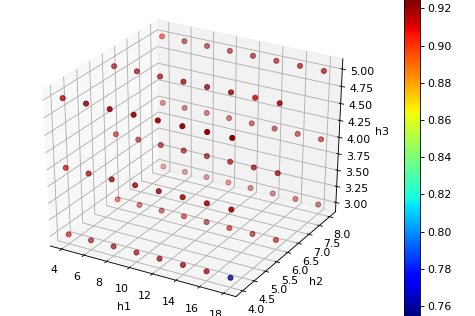

In [27]:
import matplotlib
%matplotlib notebook
with open(file_config['data_dir'] + 'mlp_grid.pkl', "rb") as f:
    res = pickle.load(f)
def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    ax.set_xlabel('h1')
    ax.set_ylabel('h2')
    ax.set_zlabel('h3')
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    plt.show()
scatter3d(res.h1,res.h2,res.h3, res.auc_res)

In [28]:
res.to_pickle(file_config['data_dir'] + 'mlp_grid.pkl')
res.sort_values(by=['auc_res'], ascending=False).head()

,h1,h2,h3,auc_res
18,8,4,3,0.924892
16,6,8,4,0.924740
40,12,6,4,0.924730
42,12,8,3,0.924378
50,14,6,5,0.924131


In [165]:
with open(file_config['data_dir'] + 'train.pkl', "rb") as f:
    train = pickle.load(f)
with open(file_config['data_dir'] + 'test.pkl', "rb") as f:
    test = pickle.load(f)

predictors = train.columns.values.tolist()
predictors = [pred for pred in predictors if ((pred != 'target_variable_ja') and (pred != 'master_number') and (pred != 'call_id'))]

X = train[predictors]
y = train['target_variable_ja']
methods = ['mlp','rf', 'xgb', 'lgbm']
pred = pd.DataFrame(np.empty((X.shape[0], len(methods))), columns=methods)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1354)
for train, test in kf.split(X, y):
    
    X_train = X.iloc[train, :]
    y_train = y.iloc[train]  
    X_test = X.iloc[test, :]
    y_test = y.iloc[test]

    model = MLPClassifier(random_state=645, max_iter=400, hidden_layer_sizes=(8, 4, 3))
    model.fit(X_train, y_train)
    pred[methods[0]][test] = model.predict_proba(X_test)[:, 1]
    
    model = RandomForestClassifier(max_depth=15, min_samples_split=50, n_estimators=100, random_state=5654, n_jobs=7)
    model.fit(X_train, y_train)
    pred[methods[1]][test] = model.predict_proba(X_test)[:, 1]
                          
    model = XGBClassifier(max_depth=13, scale_pos_weight=target_count[0] / target_count[1], eval_metric='auc',
                          gamma=30, seed=1545, colsample_bytree=0.9, min_child_weight=30, eta=1e-5)
    model.fit(X_train, y_train)
    pred[methods[2]][test] = model.predict_proba(X_test)[:, 1]
                          
    d_train = lgbm.Dataset(X_train, y_train)
    bst = lgbm.train({'metric': 'auc', 'application': 'binary', "scale_pos_weight": target_count[0] / target_count[1]}, d_train, 100)
    model = bst
    pred[methods[3]][test] = model.predict(X_test)


pred.head()

,mlp,rf,xgb,lgbm
0,0.005097,0.008565,0.009348,0.001778
1,0.703286,0.331160,0.804298,0.813221
2,0.132025,0.142510,0.802671,0.809235
3,0.000288,0.019220,0.019743,0.007525
4,0.504680,0.372306,0.866260,0.857909


In [167]:
scores = np.zeros(len(methods))
i = 0
for i, method in enumerate(methods):
    fpr, tpr, thresholds = metrics.roc_curve(y, pred[method])
    scores[i] = metrics.auc(fpr, tpr)
print("AUC for each model:")
print(methods)
print(scores)

AUC for each model:
['mlp', 'rf', 'xgb', 'lgbm']
[0.92421552 0.92769299 0.93368443 0.93282745]


## Try different strategies of ensemble

In [175]:
from sklearn.linear_model import LogisticRegression
import itertools
lst = range(len(methods))
combs = []
for i in range(2, len(lst)+1):
    els = [list(x) for x in itertools.combinations(lst, i)]
    combs.extend(els)
auc_res = [0]*len(combs)
for i_comb, comb in enumerate(combs):
    scores = np.zeros(5)
    i = 0
    for train, test in kf.split(X, y):
        X_train = pred.iloc[train, comb]
        y_train = y.iloc[train]
        X_test = pred.iloc[test, comb]
        y_test = y.iloc[test]

        model = LogisticRegression(solver='lbfgs')
        model.fit(X_train, y_train)

        fpr, tpr, thresholds = metrics.roc_curve(y_test, (model.predict_proba(X_test))[:, 1])
        scores[i] = metrics.auc(fpr, tpr)

        i += 1
    auc_res[i_comb] = scores.mean()

print("Best combination strategy:")
print(combs[np.array(auc_res).argmax()])
print("Best combination's mean AUC:")
print(np.array(auc_res).max())

Best combination strategy:
[0, 1, 2, 3]
Best combination's mean AUC:
0.9355384488159867


So best way to ensemble the models is to ensemble them all. And the ensembled model is around 0.0019 greater in AUC than the best single model XGBoost.

## The final model

In [180]:
with open(file_config['data_dir'] + 'train.pkl', "rb") as f:
    train = pickle.load(f)

predictors = train.columns.values.tolist()
predictors = [pred for pred in predictors if ((pred != 'target_variable_ja') and (pred != 'master_number') and (pred != 'call_id'))]

X = train[predictors]
y = train['target_variable_ja']
methods = ['mlp','rf', 'xgb', 'lgbm']
pred = pd.DataFrame(np.empty((X.shape[0], len(methods))), columns=methods)

X_train = X
y_train = y

model0 = MLPClassifier(random_state=645, max_iter=400, hidden_layer_sizes=(8, 4, 3))
model0.fit(X_train, y_train)
pred[methods[0]] = model0.predict_proba(X_train)[:, 1]

model1 = RandomForestClassifier(max_depth=15, min_samples_split=50, n_estimators=100, random_state=5654, n_jobs=7)
model1.fit(X_train, y_train)
pred[methods[1]] = model1.predict_proba(X_train)[:, 1]

model2 = XGBClassifier(max_depth=13, scale_pos_weight=target_count[0] / target_count[1], eval_metric='auc',
                      gamma=30, seed=1545, colsample_bytree=0.9, min_child_weight=30, eta=1e-5)
model2.fit(X_train, y_train)
pred[methods[2]] = model2.predict_proba(X_train)[:, 1]

d_train = lgbm.Dataset(X_train, y_train)
model3 = lgbm.train({'metric': 'auc', 'application': 'binary', "scale_pos_weight": target_count[0] / target_count[1]}, d_train, 100)
pred[methods[3]] = model3.predict(X_train)

model_ens = LogisticRegression(solver='lbfgs', random_state=1376)
model_ens.fit(pred, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1376, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

## Make predictions

In [182]:
with open(file_config['data_dir'] + 'test.pkl', "rb") as f:
    test = pickle.load(f)

predictors = train.columns.values.tolist()
predictors = [pred for pred in predictors if ((pred != 'target_variable_ja') and (pred != 'master_number') and (pred != 'call_id'))]

X = test[predictors]
methods = ['mlp','rf', 'xgb', 'lgbm']
pred = pd.DataFrame(np.empty((X.shape[0], len(methods))), columns=methods)

X_train = X

pred[methods[0]] = model0.predict_proba(X_train)[:, 1]
pred[methods[1]] = model1.predict_proba(X_train)[:, 1]
pred[methods[2]] = model2.predict_proba(X_train)[:, 1]
pred[methods[3]] = model3.predict(X_train)
test_pred = model_ens.predict_proba(pred)

In [191]:
print("nein: " + str(len(test_pred[:, 1][test_pred[:, 1]<=0.5])))
print("ja: " + str(len(test_pred[:, 1][test_pred[:, 1]>0.5])))
print('proportion:', round(len(test_pred[:, 1][test_pred[:, 1]<=0.5])/len(test_pred[:, 1][test_pred[:, 1]>0.5]), 4), ': 1')
# len(test_pred[:, 1][test_pred[:, 1]<=0.5])/len(test_pred[:, 1][test_pred[:, 1]>0.5])

nein: 12169
ja: 1562
proportion: 7.7907 : 1


The proportion for predicted testing data makes sense as this proportion is 7.5081 in training set.

In [192]:
with open(file_config['data_dir'] + 'prediction.pickle', 'wb') as f:
    pickle.dump(test_pred, f)

In [200]:
(pd.DataFrame({"ID": test.master_number, "Expected": np.round(test_pred[:, 1], 9)}, columns=["ID", "Expected"])).to_csv(file_config['data_dir']+"submission.csv", index=False)

## Explanatory analysis

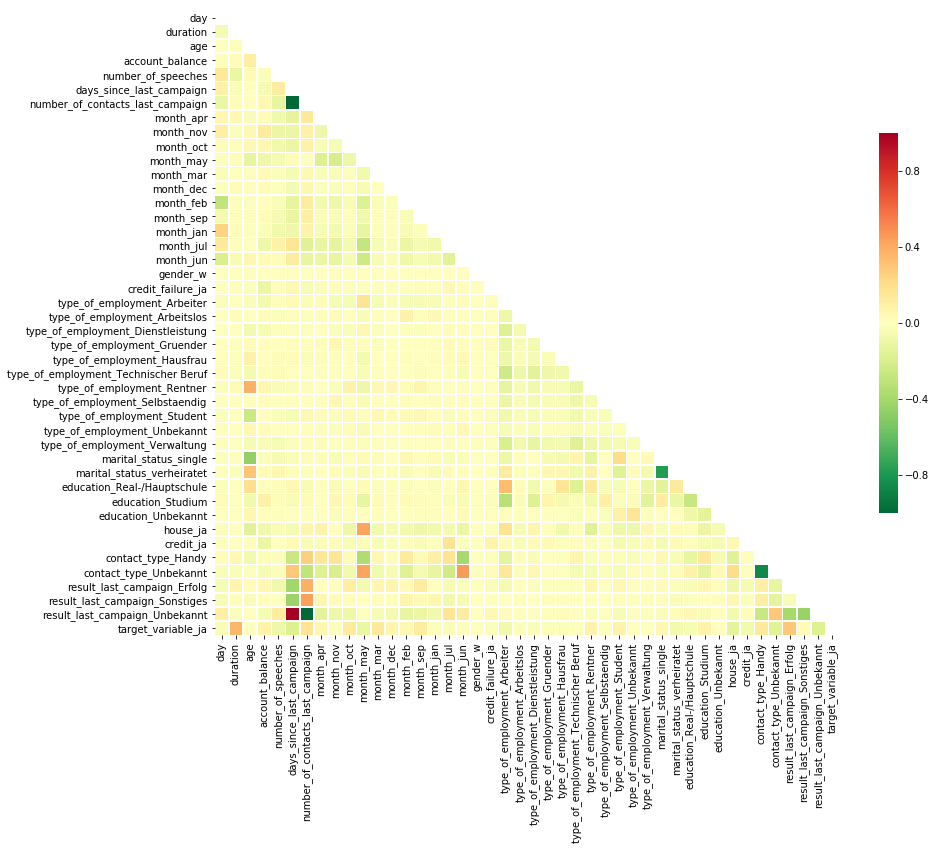

In [246]:
import seaborn as sns
%matplotlib inline

corr = train.loc[:, (train.columns != 'master_number') & (train.columns != 'call_id')].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(14, 14))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap="RdYlGn_r", vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

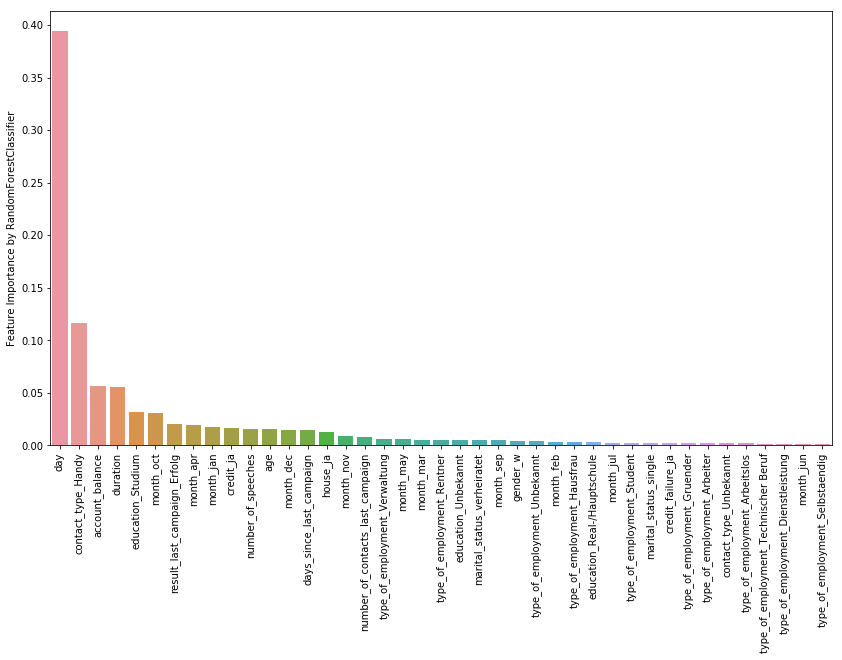

In [259]:
import seaborn.apionly as sns
import matplotlib.pyplot as plt
%matplotlib inline

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(train.columns, model1.feature_importances_):
    feats[feature] = importance #add the name/value pair 

x = list()
y = list()
for key, value in feats.items():
    if key != 'master_number' and key != 'call_id':
        x.append(key)
        y.append(value)

pairs = zip(x, y)
pairs= sorted(pairs, key=lambda x: x[1], reverse= True)

newx, newy = zip(*pairs)
f, ax = plt.subplots(figsize=(14, 8))
ax = sns.barplot(x=newx, y=newy)
plt.ylabel('Feature Importance by RandomForestClassifier')
plt.xticks(rotation=90)
plt.show()

* For which of the explanatory variables are correlations to the target variable observed?

Several variables like `duration`, `result_last_campaign_Erfolg`, `number_of_contacts_last_campaign`, `contact_type_Handy` are among most positively correlated features with `target_variable_ja`, while `days_since_last_campaign`, `result_last_campaign_Unbekannt`, `contact_type_Unbekannt`, `house_ja` are among most negatively correlated features with `target_variable_ja`. These observations make sense as one might expect that a customer who is contacted more times, or is contacted in a longer conversation, or is successfully being "completed" in last campaign, is more likely to "complete" this time, while a customer who has unknown result in last campaign, or has unknown contact type, or has missing data in `days_since_last_campaign` is less likely to "complete". It cannot be intuitively explained why customers who were contacted by mobile phones were more likely to "complete" and customers with houses were less likely to "complete".

* Which ones are technically meaningful?

Based on feature importances from random forest, `day`, `contact_type_Handy`, `account_balance`, `duration` and `education_Studium` are top five technically meaningful features.